# Proyecto 2 Data Science. Análisis Exploratorio

Autores:

- Nelson García Bravatti
- Joaquín Puente
- José Antonio Mérida



### Imports / Librerías Utilizadas
Los requerimientos para este Jupyter Notebook se pueden instalar por medio de los siguientes comandos:

Crear el entorno virtual
```
python -m venv .venv
```

Activar el entorno (Windows)

```
.\.venv\Scripts\activate
```

Activar el entorno (Linux / Max)

```
source .venv/bin/activate
```

Instalar dependencias
```
pip install -r requirements.txt
```

In [265]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from pathlib import Path
import warnings
import kagglehub

warnings.filterwarnings('ignore')

# Estilización de plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## Análisis Inicial y Preprocesamiento de Datos





### Carga del Dataset
Optamos por descargar el set de datos mediante Kagglehub, almacenando el path a los datos dentro de la variable dataset_path para su uso a futuro.

In [266]:
# Descargar la versión más reciente
path = kagglehub.dataset_download("vishakkbhat/mosquito-data")

print("Path to dataset files:", path)

Path to dataset files: /home/Tono/.cache/kagglehub/datasets/vishakkbhat/mosquito-data/versions/1


In [267]:
# Setear el path del dataset
dataset_path = path
print(f"Dataset path: {dataset_path}")

Dataset path: /home/Tono/.cache/kagglehub/datasets/vishakkbhat/mosquito-data/versions/1


### Carga a DataFrames
Este dataset contiene los datos ya divididos en splits de entrenamiento y de prueba, por lo que podemos simplemente cargar la información a DataFrames de pandas utilizando read_csv.

In [268]:
# Load the training data
train_df = pd.read_csv(os.path.join(dataset_path, 'train.csv'))
test_df = pd.read_csv(os.path.join(dataset_path, 'test_phase1.csv'))
sample_submission = pd.read_csv(os.path.join(dataset_path, 'sample_submission_phase1 (1).csv'))

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print(f"Sample submission shape: {sample_submission.shape}")

Training data shape: (8025, 8)
Test data shape: (2675, 3)
Sample submission shape: (2675, 8)


El conjunto de entrenamiento contiene 8,025 muestras con 8 características cada una, que incluyen variables predictoras y la etiqueta objetivo. Los datos de prueba constan de 2,675 muestras con 3 características, sobre los cuales deberemos realizar predicciones. La plantilla de envío confirma que se esperan 2,675 predicciones con 8 campos cada una, consistentes con el formato requerido.

### Conjunto de Entrenamiento
Podemos investigar las características específicas de cada conjunto de datos para identificar las variables predictores y etiqueta objetivo, empezando por el conjunto de datos de entrenamiento.

**Variables y Tipos de Datos**

In [269]:
print(f"Tipos de datos:\n{train_df.dtypes}")

Tipos de datos:
img_fName      object
img_w           int64
img_h           int64
bbx_xtl         int64
bbx_ytl         int64
bbx_xbr         int64
bbx_ybr         int64
class_label    object
dtype: object


El dataset de entrenamiento contiene metadatos de imágenes para el problema de detección y clasificación de mosquitos. La columna img_fName identifica cada archivo de imagen, mientras que img_w e img_h especifican sus dimensiones. Las coordenadas de las cajas delimitadoras (bbx_xtl, bbx_ytl, bbx_xbr, bbx_ybr) definen la localización precisa de los objetos dentro de las imágenes, y class_label indica la categoría de cada objeto detectado. Las columnas derivadas (bbox_width, bbox_height, bbox_area, image_area, bbox_ratio) proporcionan características adicionales calculadas a partir de las bounding boxes.

**Primeras Entradas**

In [270]:
train_df.head()

,img_fName,img_w,img_h,bbx_xtl,bbx_ytl,bbx_xbr,bbx_ybr,class_label
0,92715872-3287-4bff-aa61-7047973e5c02.jpeg,2448,3264,1301,1546,1641,2096,albopictus
1,b0f7cc74-2272-4756-a387-38bcaf6965c8.jpeg,3024,4032,900,1897,1950,2990,albopictus
2,82df4b68-0f45-4afe-9215-48488bf3720e.jpeg,768,1024,220,58,659,808,albopictus
3,331ad30a-7564-4478-b863-7bc760adf5a1.jpeg,3456,4608,1169,2364,1586,2826,albopictus
4,1a46dbfb-104e-466b-88d7-98958d7b1fe9.jpeg,1024,1365,129,231,697,1007,culex


Las primeras entradas se ven como esperamos, teniendo el nombre de la imagen, seguido de las dimensiones de la imagen y el bounding box y por último la especie del mosquito

**Operaciones de Limpieza**

Para garantizar la calidad de los datos de entrenamiento, podemos implementar las siguientes operaciones de limpieza:

**Validación de coordenadas**: Verificar que todas las bounding boxes se encuentren dentro de los límites de las imágenes (0 ≤ x ≤ img_w, 0 ≤ y ≤ img_h)

**Filtrado por tamaño**: Identificar y revisar bounding boxes anómalamente pequeñas (<10 píxeles) o excesivamente grandes (>80% del área de la imagen, estándar para modelos de visión por computadora)

**Eliminación de duplicados**: Identificar y remover bounding boxes duplicadas para la misma imagen

**Eliminación de valores nulos**: Identificar y remover valores faltantes, en este caso no sería correcto reemplazarlos con alguna otra métrica ya que el bounding box representa la totalidad de una figura geométrica.

In [271]:
original_size = len(train_df)

print(f"Problemas Detectados")

# Verificar que las bbox están dentro de los límites de la imagen
invalid_bbox_mask = (
    (train_df['bbx_xtl'] < 0) | (train_df['bbx_xtl'] >= train_df['img_w']) |
    (train_df['bbx_ytl'] < 0) | (train_df['bbx_ytl'] >= train_df['img_h']) |
    (train_df['bbx_xbr'] <= 0) | (train_df['bbx_xbr'] > train_df['img_w']) |
    (train_df['bbx_ybr'] <= 0) | (train_df['bbx_ybr'] > train_df['img_h']) |
    (train_df['bbx_xbr'] <= train_df['bbx_xtl']) |
    (train_df['bbx_ybr'] <= train_df['bbx_ytl'])
)

invalid_count = invalid_bbox_mask.sum()
print(f"Bounding boxes fuera de límites: {invalid_count}")

# Calcular dimensiones y áreas
bbox_width = train_df['bbx_xbr'] - train_df['bbx_xtl']
bbox_height = train_df['bbx_ybr'] - train_df['bbx_ytl']
bbox_area = bbox_width * bbox_height
image_area = train_df['img_w'] * train_df['img_h']
area_ratio = bbox_area / image_area

# Bounding boxes demasiado pequeñas (<10 píxeles en cualquier dimensión)
too_small_mask = (bbox_width < 10) | (bbox_height < 10)
small_count = too_small_mask.sum()
print(f"Bounding boxes muy pequeñas (<10px): {small_count}")

# Bounding boxes demasiado grandes (>80% del área de la imagen)
too_large_mask = (area_ratio > 0.8)
large_count = too_large_mask.sum()
print(f"Bounding boxes muy grandes (>80% área): {large_count}")

# Duplicados exactos en coordenadas e imagen
duplicates_mask = train_df.duplicated(
    subset=['img_fName', 'bbx_xtl', 'bbx_ytl', 'bbx_xbr', 'bbx_ybr'], 
    keep=False
)

duplicate_count = duplicates_mask.sum()
print(f"Bounding boxes duplicadas: {duplicate_count}")

# Verificar valores nulos
null_mask = train_df.isnull().any(axis=1)
null_count = null_mask.sum()
print(f"Valores nulos: {null_count}")

filter_mask = invalid_bbox_mask | too_small_mask | too_large_mask | duplicates_mask
filtered_count = filter_mask.sum()

train_df_clean = train_df[~filter_mask].copy()
final_size = len(train_df_clean)

print(f"\nResumen")
print(f"Tamaño original: {original_size}")
print(f"Registros eliminados: {filtered_count}")
print(f"Tamaño final: {final_size}")
print(f"Porcentaje conservado: {final_size/original_size*100:.2f}%")

Problemas Detectados
Bounding boxes fuera de límites: 5
Bounding boxes muy pequeñas (<10px): 1
Bounding boxes muy grandes (>80% área): 23
Bounding boxes duplicadas: 0
Valores nulos: 0

Resumen
Tamaño original: 8025
Registros eliminados: 29
Tamaño final: 7996
Porcentaje conservado: 99.64%


El proceso de limpieza identificó 29 registros problemáticos (0.36% del total), lo que indica un dataset de alta calidad. La ausencia de valores nulos y duplicados refleja una buena gestión inicial de los datos. Los principales problemas detectados son bounding boxes fuera de límites (5 casos) y dimensiones anómalas (24 casos), que probablemente corresponden a errores de anotación durante el etiquetado. La eliminación de estos registros asegura que el modelo entrene únicamente con anotaciones válidas, mejorando la confiabilidad del entrenamiento sin impactar significativamente el volumen de datos disponible (99.64% conservado).

**Visualización**

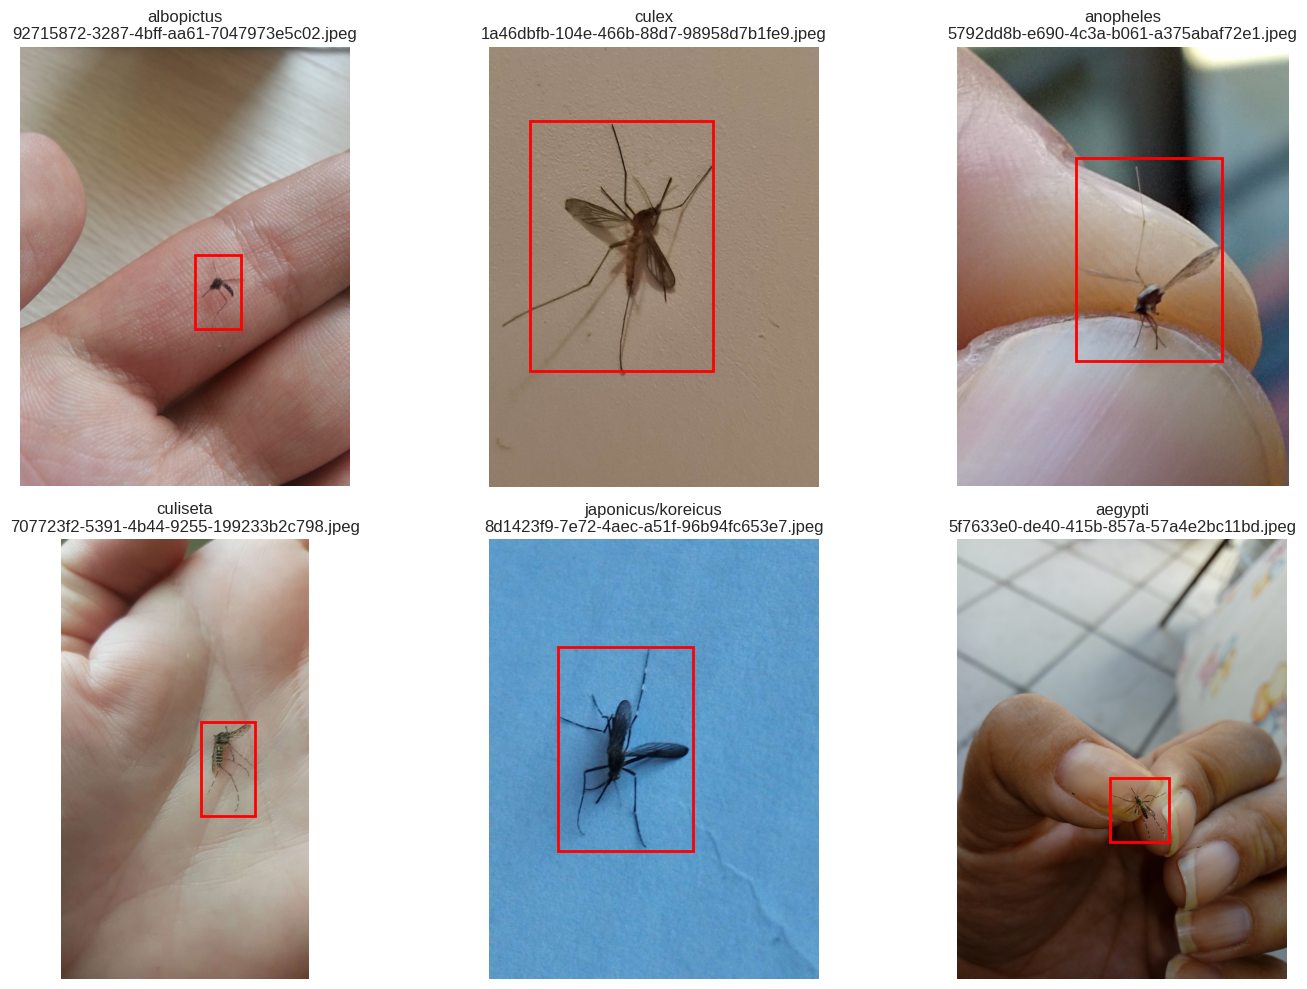

In [272]:
def display_sample_images(df, num_samples=6):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    
    # Utilizar una imagen por cada clase
    classes = df['class_label'].unique()
    
    for i, class_name in enumerate(classes[:num_samples]):
        sample = df[df['class_label'] == class_name].iloc[0]
        
        # Cargar imagen
        img_path = os.path.join(dataset_path, 'train_images', sample['img_fName'])
        
        try:
            img = Image.open(img_path)
            axes[i].imshow(img)
            
            # Dibujar bounding box
            bbox = [sample['bbx_xtl'], sample['bbx_ytl'], sample['bbx_xbr'], sample['bbx_ybr']]
            rect = plt.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], 
                               fill=False, edgecolor='red', linewidth=2)
            axes[i].add_patch(rect)
            
            axes[i].set_title(f'{class_name}\n{sample["img_fName"]}')
            axes[i].axis('off')
            
        except Exception as e:
            axes[i].text(0.5, 0.5, f'Error loading image\n{e}', 
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].set_title(f'{class_name} - Error')
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

display_sample_images(train_df)

Aquí podemos ver algunos de los ejemplos, dónde podemos observar que las imágenes tienden a tener fondos y tamaños de bounding box relativamente variados. Dentro del análisis exploratorio intentaremos encontrar diferentes patrones o tendencias para tener en mente al implementar un modelo de visión por computadora para realizar predicciones.

### Conjunto de Prueba

**Variables y Tipos de Datos**

In [273]:
print(f"Tipos de datos:\n{test_df.dtypes}")

Tipos de datos:
img_fName    object
img_w         int64
img_h         int64
dtype: object


El dataset de prueba contiene solo la información esencial para realizar inferencias: los nombres de archivo de las imágenes (img_fName) y sus dimensiones (img_w, img_h). La ausencia de bounding boxes y etiquetas de clase confirma que este es un conjunto para predicción pura, donde el modelo deberá detectar y clasificar automáticamente los mosquitos en cada imagen sin supervisión.

**Primeras Entradas**

In [274]:
test_df.head()

,img_fName,img_w,img_h
0,07e0f900-e1d2-4e3c-a812-651a156d7463.jpeg,4032,2268
1,98171e52-0def-4de8-b9ad-23cc3a1f1a2d.jpeg,2448,3264
2,30da361c-282e-4a8c-a714-4de4d5407696.jpeg,2988,5312
3,780ce034-878f-41fc-a23f-5432987ce64a.jpeg,3000,4000
4,6e7e3e96-62a4-46e3-aaa2-ce88f2949f6a.jpeg,4128,3096


Las primeras entradas se ven como esperamos, conteniendo el archivo correspondiente a la imagen al igual que sus dimensiones. Estas son las entradas para las pruebas del modelo sobre las cuales debe hacer predicciones.

**Operaciones de Limpieza**

Al ser el conjunto de prueba, no debemos realizar operaciones de limpieza sobre este conjunto.

### Resumen

**Dataset Entrenamiento:**
- **Tamaño original**: 8,025 imágenes de entrenamiento
- **Tamaño después de limpieza**: 7,966 imágenes de entrenamiento
- **Clases**: 6 especies de mosquitos (albopictus, culex, culiseta, japonicus/koreicus, anopheles, aegypti)
- **Formato**: Imágenes JPEG con anotaciones de bounding boxes

**Dataset Prueba:**
- **Tamaño**: 2,675 imágenes
- **Formato**: Imágenes JPEG

**Problemas identificados y solucionados:**
- **Bounding boxes inválidos**: 5 casos removidos
- **Bounding boxes muy pequeños**: 1 caso removido
- **Bounding boxes muy grandes**: 23 casos identificados y corregidos

## Análisis exploratorio de datos (EDA)

### Descripción de Variables y Observaciones

In [275]:
# Tamaño del Dataset
print(f"Observaciones: {train_df_clean.shape[0]}")
print(f"Variables: {train_df_clean.shape[1]}")

# Tipos de Datos
print(train_df_clean.dtypes)

Observaciones: 7996
Variables: 8
img_fName      object
img_w           int64
img_h           int64
bbx_xtl         int64
bbx_ytl         int64
bbx_xbr         int64
bbx_ybr         int64
class_label    object
dtype: object


Luego de los procesos de limpieza, el conjunto de datos cuenta con 7996 observaciones y 8 variables. Dónde cada una de las entradas cuenta con la siguiente información:

```img_fName``` (object / string - Identificador Único): Nombre del archivo de imagen (ej: "92715872-3287-4bff-aa61-7047973e5c02.jpeg")

```img_w``` (int64 - Númerica): Ancho de la imagen en píxeles

```img_h``` (int64 - Numérica): Alto de la imagen en píxeles

```bbx_xtl``` (int64 - Numérica): Coordenada X del punto superior izquierdo de la bounding box

```bbx_ytl``` (int64 - Numérica): Coordenada Y del punto superior izquierdo de la bounding box

```bbx_xbr``` (int64 - Numérica): Coordenada X del punto inferior derecho de la bounding box

```bbx_ybr``` (int64 - Numérica): Coordenada Y del punto inferior derecho de la bounding box

```class_label``` (object - Categórica): Especie de mosquito (ej: "albopictus", "culex")


Dónde ```img_w```, ```img_h```, ```bbx_xtl```, ```bbx_ytl```, ```bbx_xbr```, ```bbx_ybr``` son nuestras variables numéricas, representando las dimensiones de las imágenes y ubicación del bounding box para el mosquito.

Por otro lado, ```class_label``` es la variable categórica que buscamos predecir y ```img_fName``` corresponde al nombre del archivo de la imagen.

### Resumen de Variables Numéricas
Para las variables numéricas, iremos una por una buscando describirlas. Adicionalmente, utilizaremos algunos valores derivados como lo pueden ser altos o anchos de bounding boxes para hacerlo más robusto. Al ser coordenadas, debemos ser cuidadosos con el análisis de las medidas.

**Dimensiones de Imagen: Estadísticas Descriptivas**

In [276]:
# Formato legible en Pandas
pd.set_option('display.float_format', '{:.2f}'.format)

# Resumen de dimensiones de imagen + tamaño calculado
resumen = train_df_clean[['img_w', 'img_h']].copy()
resumen['img_area'] = resumen['img_w'] * resumen['img_h']
resumen['img_ratio'] = resumen['img_w'] / resumen['img_h']
display(resumen.describe().round(2))

,img_w,img_h,img_area,img_ratio
count,7996.00,7996.00,7996.00,7996.00
mean,2044.22,2469.48,6282548.18,0.88
std,1183.76,1358.51,5895737.90,0.35
min,152.00,106.00,16112.00,0.36
25%,1024.00,1095.00,1397760.00,0.75
50%,1847.00,2208.00,3773952.00,0.75
75%,3024.00,4000.00,12000000.00,0.98
max,9280.00,12000.00,108000000.00,2.53


En cuánto al ancho y altura de la imagen, tenemos rangos de 152px a 9280px y 2044 106px a 12000px respectivamente. Esto nos indica una alta variabilidad en el tamaño de la imagen, respaldado también por la desviación estandar de 1183.76px para el ancho y 1350.51px para la altura. Adicionalmente, utilizando la variable derivada de área podemos ver que la resolución promedio es de 6.3 megapíxeles, lo que representa una calidad aceptable-alta para modelos de visión por computadora. Sin embargo, la extrema variabilidad resulta en el 25% de las imágenes por debajo de 1.4 MPx (resolución baja) y un 25% sobre 12MPx (resolución sumamente alta). En cuanto a la relación de aspecto (img_ratio), observamos un valor promedio de 0.88 con una desviación estándar de 0.35, lo que indica una predominancia de formatos verticales en el dataset. El rango de 0.36 a 2.53 revela una diversidad significativa en las proporciones, desde imágenes muy verticales hasta formatos claramente horizontales.

**Dimensiones de Imagen: Gráficas de Distribución**

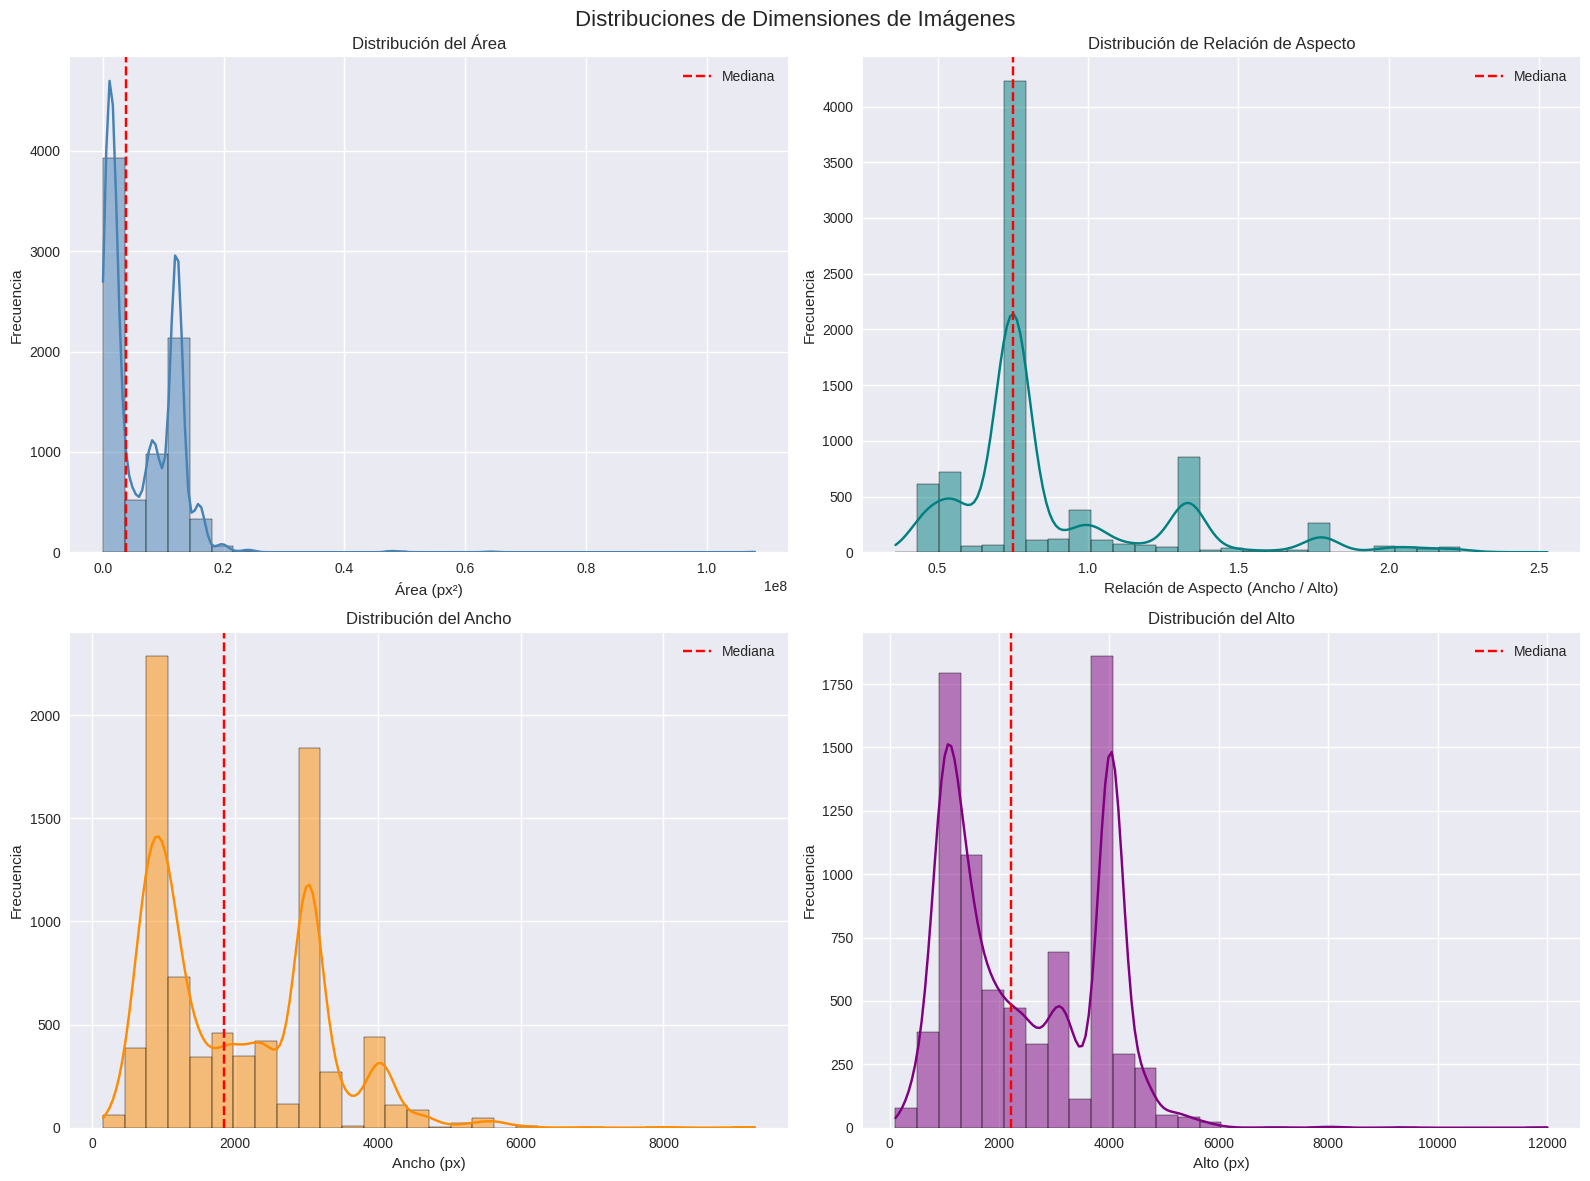

In [277]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Distribuciones de Dimensiones de Imágenes', fontsize=16)

# 1. Distribución del área
sns.histplot(resumen['img_area'], bins=30, kde=True, ax=axes[0,0], color='steelblue')
axes[0,0].axvline(resumen['img_area'].median(), color='red', linestyle='--', label='Mediana')
axes[0,0].set_xlabel('Área (px²)')
axes[0,0].set_ylabel('Frecuencia')
axes[0,0].set_title('Distribución del Área')
axes[0,0].legend()

# 2. Distribución de la relación de aspecto
sns.histplot(resumen['img_ratio'], bins=30, kde=True, ax=axes[0,1], color='teal')
axes[0,1].axvline(resumen['img_ratio'].median(), color='red', linestyle='--', label='Mediana')
axes[0,1].set_xlabel('Relación de Aspecto (Ancho / Alto)')
axes[0,1].set_ylabel('Frecuencia')
axes[0,1].set_title('Distribución de Relación de Aspecto')
axes[0,1].legend()

# 3. Distribución del ancho
sns.histplot(resumen['img_w'], bins=30, kde=True, ax=axes[1,0], color='darkorange')
axes[1,0].axvline(resumen['img_w'].median(), color='red', linestyle='--', label='Mediana')
axes[1,0].set_xlabel('Ancho (px)')
axes[1,0].set_ylabel('Frecuencia')
axes[1,0].set_title('Distribución del Ancho')
axes[1,0].legend()

# 4. Distribución del alto
sns.histplot(resumen['img_h'], bins=30, kde=True, ax=axes[1,1], color='purple')
axes[1,1].axvline(resumen['img_h'].median(), color='red', linestyle='--', label='Mediana')
axes[1,1].set_xlabel('Alto (px)')
axes[1,1].set_ylabel('Frecuencia')
axes[1,1].set_title('Distribución del Alto')
axes[1,1].legend()

plt.tight_layout()
plt.show()

**Dimensiones y Ubicacion Bounding Box**

Para esta parte, se trabajará con las coordenadas relativas del bounding box, ya que los valores absolutos dependen del tamaño de la imagen y no permiten comparar de manera consistente el tamaño o la posición de los mosquitos. Los valores relativos (0–1) indican de manera uniforme la proporción de la imagen ocupada por el mosquito y su ubicación dentro de la misma, siendo adecuados para análisis exploratorio.

In [278]:
# Coordenadas relativas del bounding box (0 a 1)
resumen['bbx_xtl_rel'] = train_df_clean['bbx_xtl'] / train_df_clean['img_w']
resumen['bbx_ytl_rel'] = train_df_clean['bbx_ytl'] / train_df_clean['img_h']
resumen['bbx_xbr_rel'] = train_df_clean['bbx_xbr'] / train_df_clean['img_w']
resumen['bbx_ybr_rel'] = train_df_clean['bbx_ybr'] / train_df_clean['img_h']

# Ancho, alto y centro relativos
resumen['bbx_w_rel'] = resumen['bbx_xbr_rel'] - resumen['bbx_xtl_rel']
resumen['bbx_h_rel'] = resumen['bbx_ybr_rel'] - resumen['bbx_ytl_rel']
resumen['bbx_cx_rel'] = (resumen['bbx_xtl_rel'] + resumen['bbx_xbr_rel']) / 2
resumen['bbx_cy_rel'] = (resumen['bbx_ytl_rel'] + resumen['bbx_ybr_rel']) / 2
resumen['bbx_area_rel'] = resumen['bbx_w_rel'] * resumen['bbx_h_rel']

# Crear DataFrame con únicamente las variables relativas del bounding box
resumen_rel = resumen[['bbx_xtl_rel', 'bbx_ytl_rel',
                       'bbx_xbr_rel', 'bbx_ybr_rel',
                       'bbx_w_rel', 'bbx_h_rel',
                       'bbx_cx_rel', 'bbx_cy_rel',
                       'bbx_area_rel']].copy()

# Mostrar estadísticas descriptivas de los valores relativos
pd.set_option('display.float_format', '{:.6f}'.format)
display(resumen_rel.describe().round(2))

,bbx_xtl_rel,bbx_ytl_rel,bbx_xbr_rel,bbx_ybr_rel,bbx_w_rel,bbx_h_rel,bbx_cx_rel,bbx_cy_rel,bbx_area_rel
count,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000
mean,0.320000,0.350000,0.660000,0.640000,0.340000,0.290000,0.490000,0.500000,0.130000
std,0.130000,0.130000,0.130000,0.130000,0.200000,0.190000,0.080000,0.090000,0.140000
min,0.000000,0.000000,0.190000,0.160000,0.020000,0.030000,0.110000,0.090000,0.000000
25%,0.240000,0.260000,0.570000,0.560000,0.180000,0.150000,0.440000,0.440000,0.030000
50%,0.330000,0.360000,0.640000,0.630000,0.290000,0.240000,0.490000,0.500000,0.070000
75%,0.410000,0.440000,0.750000,0.720000,0.460000,0.400000,0.540000,0.550000,0.180000
max,0.880000,0.800000,1.000000,1.000000,1.000000,0.970000,0.940000,0.850000,0.790000


Observando las coordenadas superiores izquierdas (```bbx_xtl_rel```, ```bbx_ytl_rel```) tienen medias de 0.32 y 0.35 respectivamente, indicando que en promedio, los mosquitos se encuentran ligeramente desplazados al centro desde la esquina superior izquierda. Las coordenadas inferiores derechas (```bbx_xbr_rel```, ```bbx_ybr_rel```) presentan medias de 0.66 y 0.64, sugiriendo que los bounding boxes ocupan aproximadamente un tercio a la mitad del ancho y alto de la imagen. En cuanto a desviación estándar, es relativamente baja. Esto indica que la mayoría de mosquitos se encuentran en posiciones similares, aunque los valores de mínimos y máximos indican que hay casos en dónde los mosquitos aparecen cerca de los bordes.

En cuanto al tamaño relativo del bounding box, bbx_w_rel y bbx_h_rel muestran medias de 0.34 y 0.29, respectivamente, con una dispersión moderada (desviaciones estándar de 0.20 y 0.19), lo que indica que la mayoría de los mosquitos ocupan un área pequeña a media dentro de la imagen, aunque hay algunos bounding boxes que cubren hasta casi la totalidad del ancho o del alto de la imagen (máximos de 1.0 y 0.97). La media del área relativa (bbx_area_rel) es de 0.13, lo que confirma que los mosquitos suelen ocupar alrededor del 13 % del área total de la imagen, con casos extremos donde el área del bounding box puede alcanzar hasta un 79 % de la imagen.

Respecto al centro del bounding box (bbx_cx_rel, bbx_cy_rel), las medias de 0.49 y 0.50 indican que, en promedio, los mosquitos están centrados tanto horizontal como verticalmente dentro de las imágenes, lo cual es útil para modelos de detección que pueden asumir que el objeto de interés tiende a aparecer cerca del centro. Sin embargo, los valores mínimo y máximo muestran cierta variabilidad, con centros que van desde casi un décimo hasta cerca del borde de la imagen, lo que sugiere que el modelo también debe ser capaz de generalizar a posiciones no centrales.

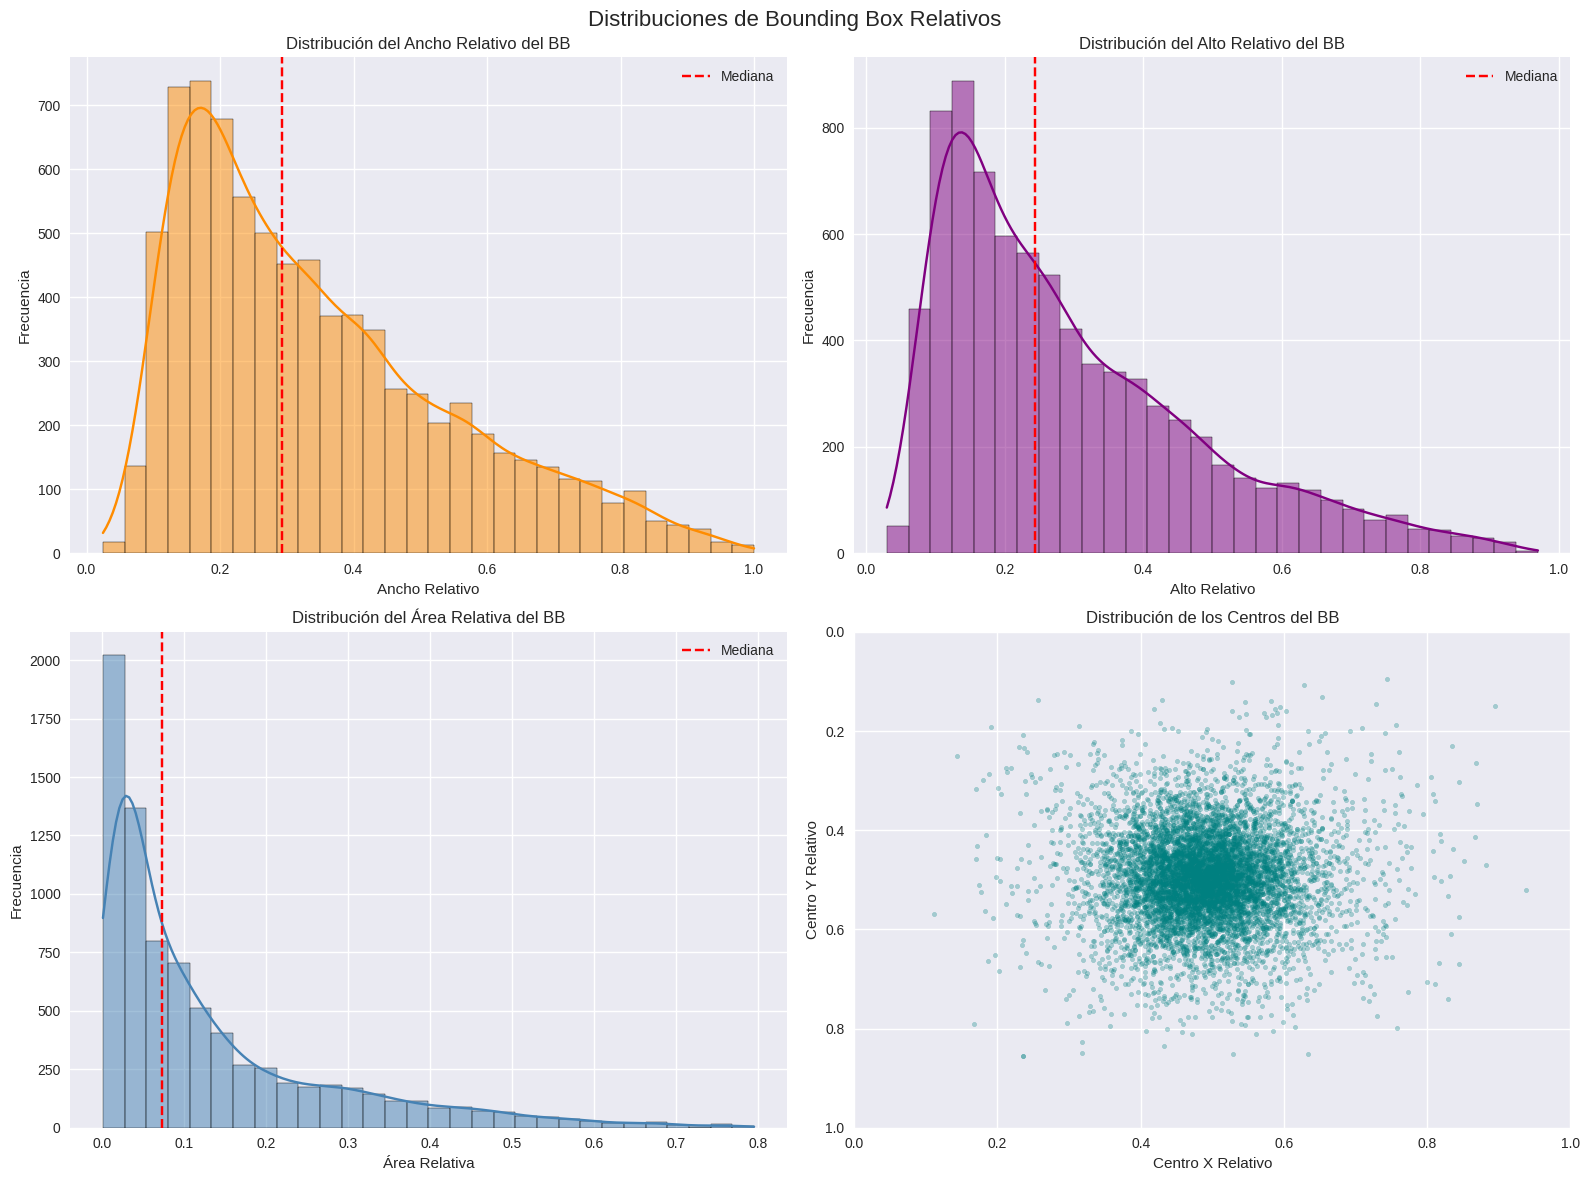

In [281]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Distribuciones de Bounding Box Relativos', fontsize=16)

# 1. Distribución del ancho relativo
sns.histplot(resumen['bbx_w_rel'], bins=30, kde=True, ax=axes[0,0], color='darkorange')
axes[0,0].axvline(resumen['bbx_w_rel'].median(), color='red', linestyle='--', label='Mediana')
axes[0,0].set_xlabel('Ancho Relativo')
axes[0,0].set_ylabel('Frecuencia')
axes[0,0].set_title('Distribución del Ancho Relativo del BB')
axes[0,0].legend()

# 2. Distribución del alto relativo
sns.histplot(resumen['bbx_h_rel'], bins=30, kde=True, ax=axes[0,1], color='purple')
axes[0,1].axvline(resumen['bbx_h_rel'].median(), color='red', linestyle='--', label='Mediana')
axes[0,1].set_xlabel('Alto Relativo')
axes[0,1].set_ylabel('Frecuencia')
axes[0,1].set_title('Distribución del Alto Relativo del BB')
axes[0,1].legend()

# 3. Distribución del área relativa
sns.histplot(resumen['bbx_area_rel'], bins=30, kde=True, ax=axes[1,0], color='steelblue')
axes[1,0].axvline(resumen['bbx_area_rel'].median(), color='red', linestyle='--', label='Mediana')
axes[1,0].set_xlabel('Área Relativa')
axes[1,0].set_ylabel('Frecuencia')
axes[1,0].set_title('Distribución del Área Relativa del BB')
axes[1,0].legend()

# 4. Scatter de los centros relativos
axes[1,1].scatter(resumen['bbx_cx_rel'], resumen['bbx_cy_rel'], alpha=0.3, s=10, color='teal')
axes[1,1].set_xlabel('Centro X Relativo')
axes[1,1].set_ylabel('Centro Y Relativo')
axes[1,1].set_title('Distribución de los Centros del BB')
axes[1,1].set_xlim(0,1)
axes[1,1].set_ylim(0,1)
axes[1,1].invert_yaxis()  # Para coincidir con coordenadas de imagen (0,0 arriba izquierda)

plt.tight_layout()
plt.show()


### Resumen de Variables Categóricas

In [282]:
# Frequency table for class_label
freq_table = train_df_clean['class_label'].value_counts().reset_index()
freq_table.columns = ['class_label', 'count']
freq_table['percentage'] = (freq_table['count'] / freq_table['count'].sum() * 100).round(2)

# Display the table
display(freq_table)


,class_label,count,percentage
0,albopictus,3557,44.480000
1,culex,3533,44.180000
2,culiseta,488,6.100000
3,japonicus/koreicus,319,3.990000
4,anopheles,63,0.790000
5,aegypti,36,0.450000


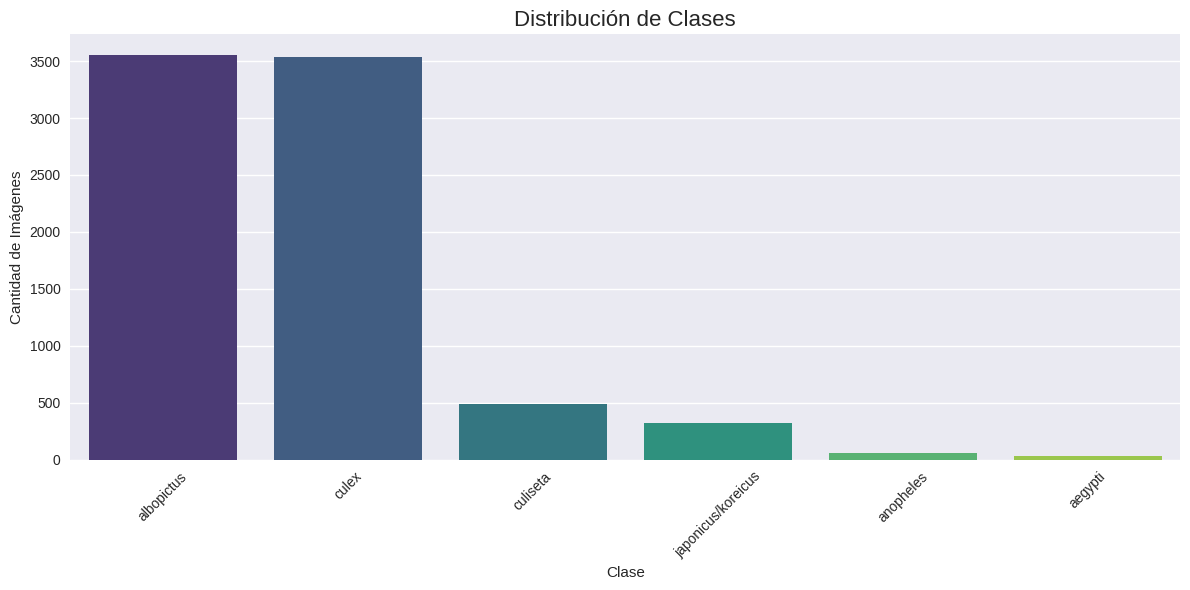

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Frequency table
freq_table = train_df_clean['class_label'].value_counts().reset_index()
freq_table.columns = ['class_label', 'count']

# Bar plot
plt.figure(figsize=(12,6))
sns.barplot(data=freq_table, x='class_label', y='count', palette='viridis')
plt.title('Distribución de Clases', fontsize=16)
plt.xlabel('Clase')
plt.ylabel('Cantidad de Imágenes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Patrones Clave
Realizar cruces entre variables clave para detectar patrones relevantes.